In [139]:
import numpy as np
import pandas as pd

import datetime
import json

import polyline

from matplotlib import pyplot as plt
import folium

import branca.colormap

In [30]:
time_format = '%Y-%m-%dT%XZ'
time_str='2016-05-18T21:47:52Z'
incdttm = datetime.datetime.strptime(time_str, time_format)
days = today.date() - incdttm.date()
days.days

1643

In [151]:
# data_file = 'seattle_riding_segments.txt'
# data_file = 'seattle_top_segments_details.txt'
data_file = 'seattle_ucity_top_segments_details_combined.txt'

today = datetime.datetime(2020, 11, 16)
time_format = '%Y-%m-%dT%XZ'

all_coords = []
all_ave_efforts = []
all_seg_ind = []

with open(data_file) as f:
    for line in f:
        if not line.strip():
            continue

        data = json.loads(line)
        if 'id' not in data:
            continue
                
        coords = polyline.decode(data['map']['polyline'])
        all_coords.extend(coords)
        # find the date when the segment was created, in order to calculate the average efforts (volume)
        days = today.date() - datetime.datetime.strptime(data['created_at'], time_format).date()
        ave_efforts = np.round(data['effort_count']/days.days, 2)
        all_ave_efforts.extend([ave_efforts]*len(coords))
        all_seg_ind.extend([data['id']]*len(coords))
        
#         print(f"[{data['name']}]")
#         print(f"Created for {days.days} days")
#         print(f"Coordinates ({len(coords)}): {coords[:5]}")
#         print(f"Total efforts: {data['effort_count']} by {data['athlete_count']} athletes")
#         print(f"Average efforts: {ave_efforts}")
#         print("\n")

In [152]:
lats, lngs = zip(*all_coords)

seattle_riding_volume = {}
seattle_riding_volume['lats'] = np.round(np.array(lats), 3) 
seattle_riding_volume['lngs'] = np.round(np.array(lngs), 3)
seattle_riding_volume['volume'] = all_ave_efforts
seattle_riding_volume['seg_id'] = all_seg_ind
df = pd.DataFrame(seattle_riding_volume)
df.head()
print(df.shape)

(8547, 4)


### Show these coordinates with bicycle traffic volume on a map

In [154]:
# groupby coarse positions
df_seg = df.groupby(['lats', 'lngs', 'seg_id'])['volume'].max().reset_index()

df_grid = df_seg.groupby(['lats', 'lngs'])['volume'].sum().reset_index()
df_grid.shape

(833, 3)

In [155]:
df_grid['volume'].max()

514.11

array([  7.36  ,  29.01  ,  98.99  , 187.494 , 391.3484])

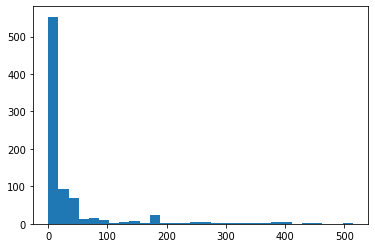

In [168]:
plt.hist(df_grid['volume'], 30);
np.percentile(df_grid['volume'], [50, 75, 90, 95, 99])

In [131]:
df_grid.shape

(558, 3)

In [163]:
# colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1)
colormap = branca.colormap.LinearColormap(
    ['yellow', 'green', 'purple'],
    vmin=0, vmax=200,
    caption='Color Scale for Bicycle Volume' #Caption for Color scale or Legend
)
colormap.rgb_hex_str(.1)

'#ffff00'

In [166]:
seattle_map = folium.Map(location=[df["lats"].mean(), df["lngs"].mean()], tiles='Stamen Toner',
                             zoom_start=14, control_scale=True, min_zoom=10)
colormap.add_to(seattle_map)
for ind in range(df_grid.shape[0]):
    folium.Circle(
        radius=15,
        location=df_grid.iloc[ind][['lats','lngs']],
        color=colormap.rgb_hex_str(df_grid.iloc[ind]['volume']),
        fill=True,
        weight=5,
        #fillOpacity=1.0
    ).add_to(seattle_map)
        
seattle_map
# plt.savefig('bicycle_volume')